そもそも何を予測する？<br>
1. vote_average
2. vote_count
3. profit


### Config

In [4]:
import os

import warnings
from pathlib import Path
from glob import glob

import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
warnings.simplefilter("ignore")

from collections import defaultdict, Counter
from functools import partial
import json
import pickle
from tqdm import tqdm

import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [5]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [6]:
INPUT_DIR = "../data/input/TMDB/"
OUTPUT_DIR = "../data/output/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [7]:
"""
# kaggle APIからdatasetをzip形式でDownload
# zipファイルをINPUT_DIRに解凍するコード
# 初めの一回のみ動かす

import shutil
shutil.unpack_archive(INPUT_DIR+'tmdb-movie-metadata.zip', INPUT_DIR)
"""


"\n# kaggle APIからdatasetをzip形式でDownload\n# zipファイルをINPUT_DIRに解凍するコード\n# 初めの一回のみ動かす\n\nimport shutil\nshutil.unpack_archive(INPUT_DIR+'tmdb-movie-metadata.zip', INPUT_DIR)\n"

### load data

In [8]:
credit = pd.read_csv(INPUT_DIR+'tmdb_5000_credits.csv')
movie = pd.read_csv(INPUT_DIR+'tmdb_5000_movies.csv')

In [9]:
credit.columns = ['id', 'title', 'cast', 'crew']
movie_df = movie.merge(credit[['id', 'cast', 'crew']], on='id')
movie_df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


### preprocess

In [10]:
# to datetime
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month

In [11]:
# json形式で格納されているcolumnsに対して前処理
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries',
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew":
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

# create director writer and producer columns
# drop crew column
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job]
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))
movie_df.drop('crew', axis=1, inplace=True)

# create profit column
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

In [12]:
# 最頻値を用いて欠損値埋め
for col in ['runtime', 'release_year', 'release_month']:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [13]:
movie_df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,cast,release_year,release_month,director,writer,producer,profit
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",2009.0,12.0,James Cameron,James Cameron,James Cameron,2550965087


In [14]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                4803 non-null   int64         
 1   genres                4803 non-null   object        
 2   homepage              1712 non-null   object        
 3   id                    4803 non-null   int64         
 4   keywords              4803 non-null   object        
 5   original_language     4803 non-null   object        
 6   original_title        4803 non-null   object        
 7   overview              4800 non-null   object        
 8   popularity            4803 non-null   float64       
 9   production_companies  4803 non-null   object        
 10  production_countries  4803 non-null   object        
 11  release_date          4802 non-null   datetime64[ns]
 12  revenue               4803 non-null   int64         
 13  runtime           

#### todo
以下の特徴量を追加
- genre
  - one-hot?
- keywords
  - ベクトル化
- original_title
  - ベクトル化？
- overview
- production_companies
- production_countries
- tagline
- title
  - original_titleと同じ？
- director
  - n回以上登場している人が作っているものは1、それ以外は0とか？
- writer
  - 同上
- producer
  - 同上

In [15]:
cat_cols = ['id', 'genres', 'homepage', 'keywords', 'original_title', 'overview','production_countries', 'production_companies', 'spoken_languages', 'tagline', 'title', 'cast', 'director', 'writer', 'producer', 'status', 'release_date']

In [16]:
# original_language
# statusはReleasedのみを使用
# vote_count>=20を使用(20に特別な意味なし)
train_df = pd.get_dummies(movie_df, columns=['original_language'])
train_df = train_df[train_df['status']=='Released']
train_df = train_df[train_df['vote_count']>=20]
train_df.drop(cat_cols, axis=1, inplace=True)

### Model

In [17]:
def fit_lgbm(X,
            y,
            cv,
            params: dict=None,
            verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float64)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSE: {:.4f}'.format(score))
    return oof_pred, models

In [18]:
params = {
    'objective': 'rmse',
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'colsample_bytree': .5,
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,

    'importance_type': 'gain',
    'random_state': 510,
}

In [19]:
X = train_df.drop('vote_average', axis=1)
y = train_df['vote_average'].values
fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X, y))

In [20]:
oof, models = fit_lgbm(X.values, y, cv, params=params, verbose=500)

fit fold=0  0.573[s]
Fold 0 RMSLE: 0.6289
fit fold=1  0.345[s]
Fold 1 RMSLE: 0.6313
fit fold=2  0.369[s]
Fold 2 RMSLE: 0.6606
fit fold=3  0.650[s]
Fold 3 RMSLE: 0.5811
fit fold=4  0.279[s]
Fold 4 RMSLE: 0.6288
--------------------------------------------------
FINISHED | Whole RMSE: 0.6267


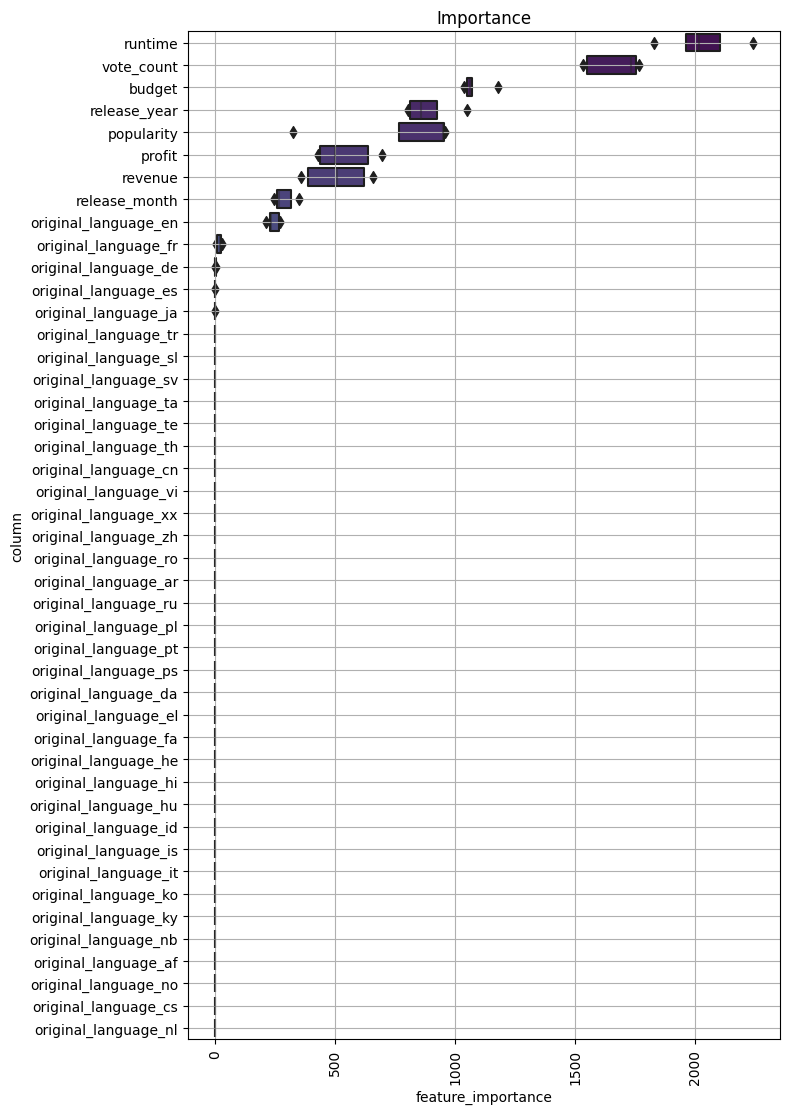

In [21]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
        axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                x='feature_importance',
                y='column',
                order=order,
                ax=ax,
                palette='viridis',
                orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, X)

### Shapを用いた可視化

In [22]:
import shap

In [24]:
explainer = shap.TreeExplainer(models[0], data=X)

In [25]:
train_x_shap_val = explainer.shap_values(X)

 94%|=================== | 3886/4137 [00:11<00:00]       

In [38]:
shap_vals = explainer(X)

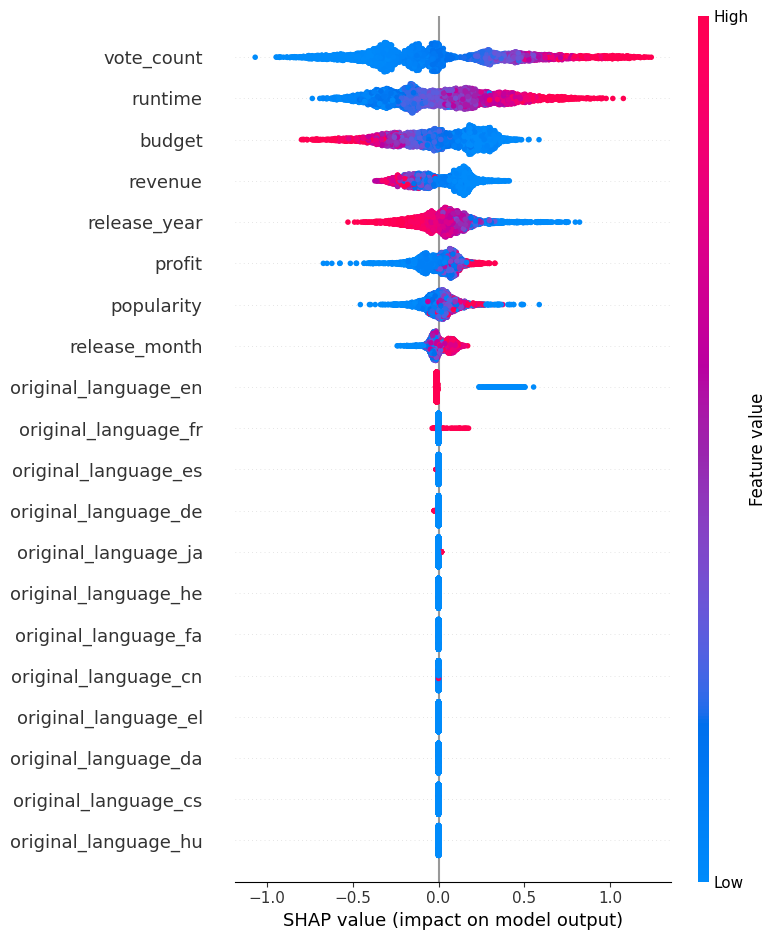

In [26]:
shap.summary_plot(shap_values=train_x_shap_val, features=X, feature_names=X.columns)

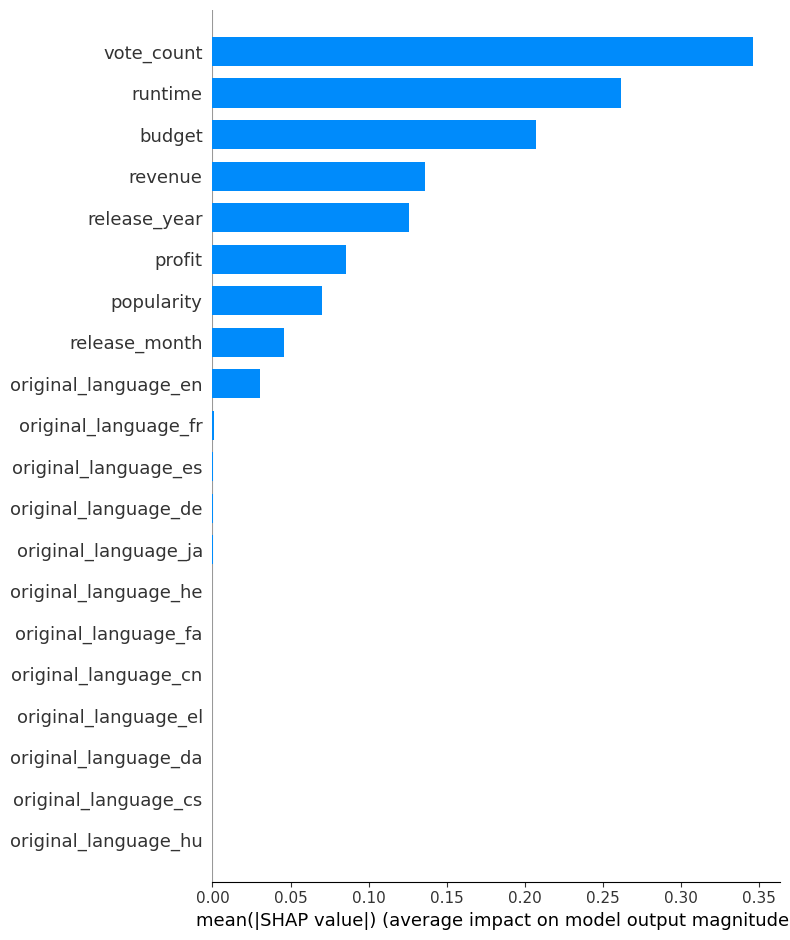

In [27]:
shap.summary_plot(shap_values=train_x_shap_val, features=X,
                    feature_names=X.columns, plot_type='bar')

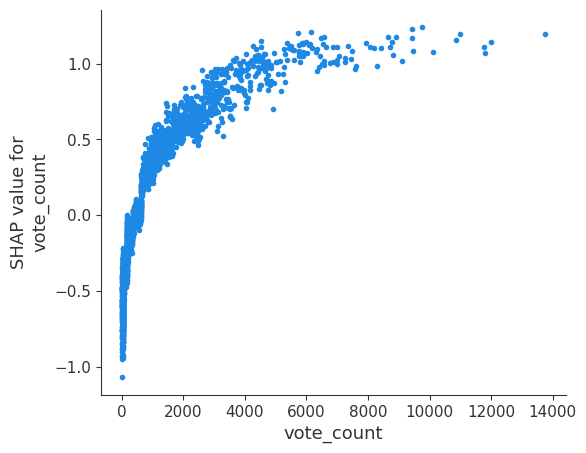

In [28]:
shap.dependence_plot(ind='vote_count', interaction_index=None,
                    shap_values=train_x_shap_val, features=X, feature_names=X.columns)

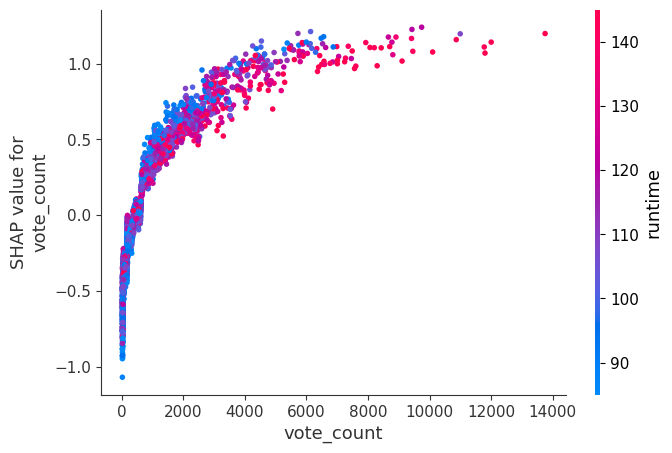

In [29]:
shap.dependence_plot(ind='vote_count', interaction_index='runtime',
                    shap_values=train_x_shap_val, features=X, feature_names=X.columns)

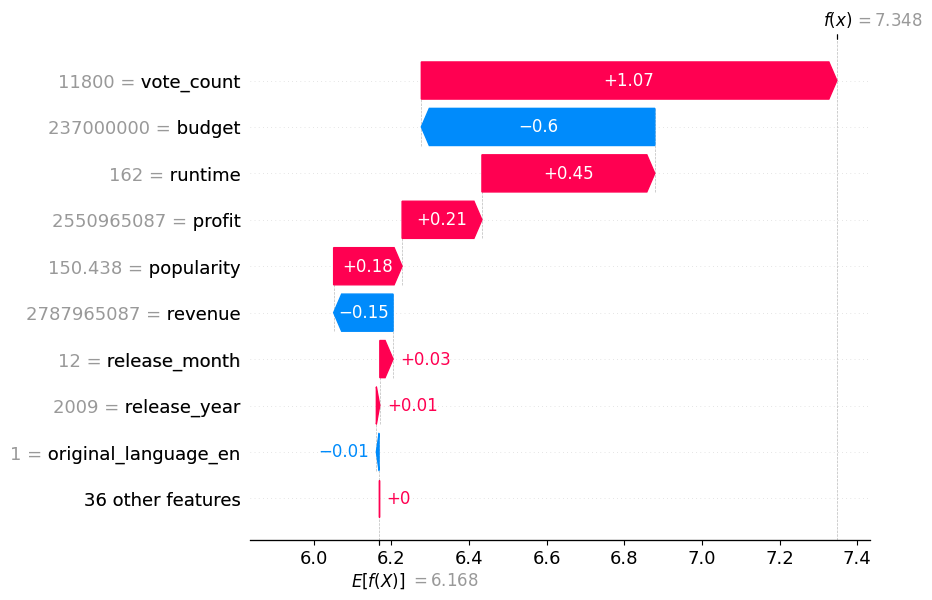

In [40]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
shap.plots.waterfall(shap_vals[0])